In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,image
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,auc,classification_report
from sklearn.metrics import accuracy_score


In [3]:
vgg_model=VGG16(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling="avg")

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
for layer in vgg_model.layers[:16]:
    layer.trainable=False   

In [5]:
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers)

,0,1,2
0,<keras.engine.input_layer.InputLayer object at 0x7ffac5395b70>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7ffaa7556dd8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7ffaa7556f60>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7ffaa7075080>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7ffaa70757f0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7ffaa702d5c0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7ffaa7048518>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7ffaa7048cc0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7ffaa6ff97b8>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7ffaa6f96a58>,block3_conv3,False


In [6]:
model=Sequential()
model.add(vgg_model)
model.add(Dropout(0.5))
model.add(Dense(426))
model.add(Dense(10,activation="softmax"))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 426)               218538    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4270      
Total params: 14,937,496
Trainable params: 4,942,424
Non-trainable params: 9,995,072
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
train_dir=Path("/content/drive/My Drive/train set")
BATCH_SIZE=64
val_dir=Path("/content/drive/My Drive/val set")

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255
)

val_datagen=ImageDataGenerator(
    rescale=1./255 
)

train_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset=None,
    shuffle=True,
    seed=22
)

val_gen=val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=10,
    class_mode="categorical",
    subset=None,
    shuffle=True,
    seed=22
)

In [9]:
model.load_weights("weight.h5")

In [ ]:
hist=model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.n/BATCH_SIZE,
    epochs=1,
    validation_data=val_gen,
    validation_steps=val_gen.n/10,
    verbose=1
)

## Predictions

In [11]:
test_path=Path("test set")

In [12]:
test_datagen=ImageDataGenerator(
     rescale=1./255
)

In [13]:
test_generator=test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None, #return batches of images for prediction
    shuffle=False 
)


Found 100 images belonging to 10 classes.


In [ ]:
model.evaluate_generator(
     generator=val_gen,
     steps=val_gen.n/1
)

In [15]:
test_generator.reset()
pred=model.predict_generator(
    test_generator,
    steps=test_generator.n//test_generator.batch_size,
    verbose=1
    )

100/100 [==============================] - 77s 768ms/step


In [16]:
#prediction
indices=np.argmax(pred,axis=1)

label2index=test_generator.class_indices 
index2label={v:k for k,v in label2index.items()}

label_pred=[index2label[i] for i in indices]

In [17]:
#true labels
label_index=test_generator.classes
true_label=[index2label[i] for i in label_index]

In [18]:
#confusion matrix
mat=confusion_matrix(true_label,label_pred)

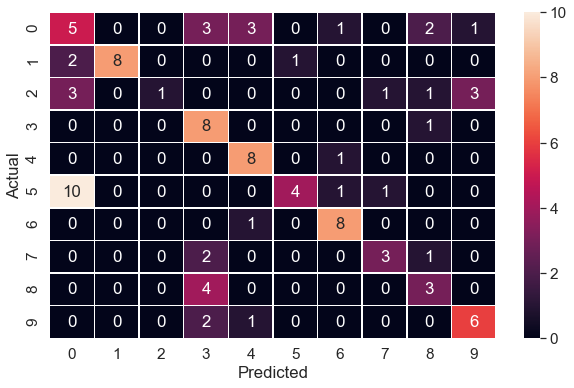

In [20]:
#plot confusion matrix
df=pd.DataFrame(mat,index=list(test_generator.class_indices),columns=list(test_generator.class_indices))
plt.figure(figsize=(10,6))
sn.set(font_scale=1.4)
sn.heatmap(mat,annot=True,linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
print (classification_report(true_label,label_pred)) 

              precision    recall  f1-score   support

       blues       0.25      0.33      0.29        15
   classical       1.00      0.73      0.84        11
     country       1.00      0.11      0.20         9
       disco       0.42      0.89      0.57         9
      hiphop       0.62      0.89      0.73         9
        jazz       0.80      0.25      0.38        16
       metal       0.73      0.89      0.80         9
         pop       0.60      0.50      0.55         6
      reggae       0.38      0.43      0.40         7
        rock       0.60      0.67      0.63         9

    accuracy                           0.54       100
   macro avg       0.64      0.57      0.54       100
weighted avg       0.64      0.54      0.52       100

